# Classification with Random Forest

## Import the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

Set the rng seed.

In [2]:
seed = 17

## Import and view data

In [4]:
df = pd.read_csv("data/train_prepd_3.csv")
display(df.head())
print('dims: ', df.shape)

,Survived,Pclass,Age,Fare,FamSize,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_M,Deck_T
0,0.0,3,22.0,7.2500,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0
1,1.0,1,38.0,71.2833,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
2,1.0,3,26.0,7.9250,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0
3,1.0,1,35.0,53.1000,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
4,0.0,3,35.0,8.0500,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0


dims:  (891, 20)


Data have already been preprocessed, as part of the EDA step. Including one-hot encoding and imputation of missing values.

Split into dependent and independent variables.

In [5]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

## Build a preliminary classification tree

Split into testing and training data.

Data are somewhat imbalanced (38% survived). We'll be using stratification in the train/test splits as well in our cross-validation later on.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = seed)

Build and train a simple random forest classifier. Use to predict test values.

Accuracy: 83.80 %


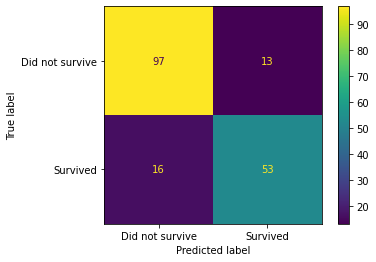

In [7]:
# build the model shell and fit onto the training data.
clf_prel = RandomForestClassifier(random_state=seed)
clf_prel.fit(X_train, y_train)

# predict
y_pred = clf_prel.predict(X_test)

# results
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Accuracy: {:.2f} %'.format(acc * 100))
plot_confusion_matrix(clf_prel, 
                     X_test,
                     y_test, display_labels=['Did not survive', 'Survived'])

Use the model to predict training values in order to assess overfitting.

Accuracy: 99.16 %


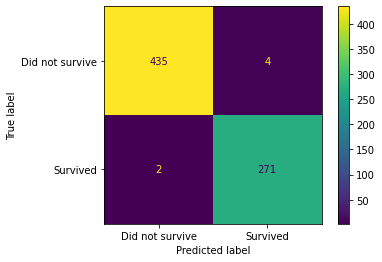

In [8]:
y_pred_tr = clf_prel.predict(X_train)

acc = accuracy_score(y_train, y_pred_tr)
cm = confusion_matrix(y_train, y_pred_tr)

print('Accuracy: {:.2f} %'.format(acc * 100))
plot_confusion_matrix(clf_prel, 
                     X_train,
                     y_train, display_labels=['Did not survive', 'Survived'])

Use repeated and stratified 10-fold cross validation to get a more robust estimate of the model's accuracy.

In [9]:
# Create the cv tactic.
cv_rep_str = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)

# Get CV accuracy and st dev.
scores = cross_val_score(clf_prel, X, y, cv=cv_rep_str)

print('scores: ', scores )
print('Accuracy: {:.2f} %'.format(scores.mean() * 100))
print('St.dev: {:.4f}'.format(scores.std()))

scores:  [0.82222222 0.88764045 0.75280899 0.78651685 0.78651685 0.7752809
 0.84269663 0.80898876 0.85393258 0.82022472 0.77777778 0.79775281
 0.78651685 0.83146067 0.83146067 0.80898876 0.76404494 0.84269663
 0.86516854 0.80898876 0.85555556 0.7752809  0.82022472 0.82022472
 0.86516854 0.76404494 0.92134831 0.78651685 0.82022472 0.80898876
 0.8        0.84269663 0.76404494 0.79775281 0.80898876 0.83146067
 0.82022472 0.80898876 0.85393258 0.78651685 0.77777778 0.80898876
 0.84269663 0.82022472 0.7752809  0.82022472 0.85393258 0.82022472
 0.80898876 0.79775281]
Accuracy: 81.46 %
St.dev: 0.0336


## Hyper-parameter tuning

Random forest tends to perform quite well out of the box. We will try tuning some of the hyper-parameters to see if we can get an increase in accuracy. We'll mostly try a couple different values for maximum tree depth to see if we can reduce overfitting.

In [10]:
# Set up the hyper-parameter grid for Grid Search.

params = {'max_features': ['sqrt'], 
        'criterion': ['gini', 'entropy'], 
        'max_depth': [2, 4, 6, 8, 10],
         'n_estimators': [5, 10, 20, 50, 100]}

In [11]:
# build the shell model and fit on training data.
clf = RandomForestClassifier(random_state=seed)
gs = GridSearchCV(estimator=clf, param_grid=params, n_jobs=-1, cv=10)
gs.fit(X, y)

# print the best models and hyper-parameters
results = gs.cv_results_
best = gs.best_params_
display(pd.DataFrame(results).sort_values(by='rank_test_score').head(3))
print('best values of hyper-parameters', best)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
42,0.031228,0.001830,0.003658,0.000444,entropy,8,sqrt,20,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.800000,...,0.876404,0.921348,0.853933,0.797753,0.808989,0.887640,0.842697,0.839551,0.047492,1
43,0.071376,0.001423,0.006106,0.000202,entropy,8,sqrt,50,"{'criterion': 'entropy', 'max_depth': 8, 'max_...",0.822222,...,0.876404,0.898876,0.865169,0.831461,0.797753,0.887640,0.820225,0.838402,0.044642,2
38,0.070571,0.002438,0.006260,0.000401,entropy,6,sqrt,50,"{'criterion': 'entropy', 'max_depth': 6, 'max_...",0.822222,...,0.887640,0.853933,0.842697,0.842697,0.808989,0.865169,0.853933,0.838402,0.032147,3


best values of hyper-parameters {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 20}


## Build the final model

Accuracy: 84.36 %


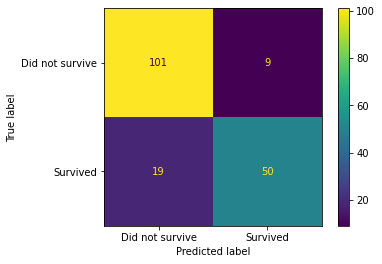

In [12]:
clf = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators = 20, max_features='sqrt', random_state=seed)
clf.fit(X_train, y_train)

# predict
y_pred = clf.predict(X_test)

# results
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Accuracy: {:.2f} %'.format(acc * 100))
plot_confusion_matrix(clf, 
                     X_test,
                     y_test, display_labels=['Did not survive', 'Survived'])

Use 10-fold CV to get a more robust estimate of the model's accuracy.

In [13]:
# Create the cv tactic.
cv_rep_str = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)

# Get CV accuracy and st dev.
scores = cross_val_score(clf, X, y, cv=cv_rep_str)

print('scores: ', scores )
print('Accuracy: {:.2f} %'.format(scores.mean() * 100))
print('St.dev: {:.4f}'.format(scores.std()))

scores:  [0.84444444 0.85393258 0.7752809  0.79775281 0.78651685 0.78651685
 0.87640449 0.85393258 0.87640449 0.86516854 0.77777778 0.83146067
 0.80898876 0.84269663 0.85393258 0.82022472 0.80898876 0.86516854
 0.87640449 0.80898876 0.88888889 0.86516854 0.79775281 0.84269663
 0.85393258 0.78651685 0.86516854 0.83146067 0.79775281 0.7752809
 0.84444444 0.84269663 0.79775281 0.75280899 0.85393258 0.84269663
 0.80898876 0.79775281 0.87640449 0.83146067 0.78888889 0.80898876
 0.83146067 0.80898876 0.74157303 0.79775281 0.87640449 0.86516854
 0.83146067 0.80898876]
Accuracy: 82.65 %
St.dev: 0.0355


We got a bit more than 1% in accuracy improvement. The final random forest classifier has an accuracy of 82.65%.

Text(0.5, 0, 'Random Forest Feature Importance')

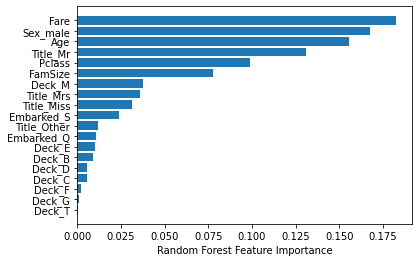

In [14]:
sorted_idx = clf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")